In [12]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')


In [3]:
video_df = pd.read_csv('/data/mskscratch/users/ghoyer/Precision_Air/air_loc_processed_vid_details_0424_standardized.csv')
video_df

,Video_ID,Video_path,Video_ext,Santiago_Review,Sean_Review,Santiago_Total_time_of_attempt,Sean_Total_time_of_attempt,Santiago_Total_time_of_tracheal_access,Sean_Total_time_of_tracheal_access,Santiago_new_blood_erythema,...,Santiago_Total_time_of_attempt_std,Sean_Total_time_of_attempt_std,Santiago_Total_time_of_tracheal_access_std,Sean_Total_time_of_tracheal_access_std,Santiago_Best_CL_grade_std,Santiago_Best_CL_grade_num,Sean_Best_CL_grade_std,Sean_Best_CL_grade_num,Santiago_new_blood_erythema_std,Sean_new_blood_erythema_std
0,20201029-170946,/data/mskscratch/users/ghoyer/Precision_Air/Da...,.avi,2b,2,24.0,15,17.0,7,NaN,...,24.0,15.0,17.0,7.0,1,1,1,1,NaN,NaN
1,20201026-094437,/data/mskscratch/users/ghoyer/Precision_Air/Da...,.avi,1,1,16.0,6,10.0,3,NaN,...,16.0,6.0,10.0,3.0,1,1,1,1,NaN,NaN
2,20201011-041330,/data/mskscratch/users/ghoyer/Precision_Air/Da...,.avi,2b,2,24.0,11,17.0,5,NaN,...,24.0,11.0,17.0,5.0,2a,2,2,2,NaN,NaN
3,20201019-154106,/data/mskscratch/users/ghoyer/Precision_Air/Da...,.avi,2b,2,43.0,16,33.0,10,NaN,...,43.0,16.0,33.0,10.0,1,1,1,1,NaN,NaN
4,20201016-124433,/data/mskscratch/users/ghoyer/Precision_Air/Da...,.avi,2d,2,17.0,10,13.0,4,NaN,...,17.0,10.0,13.0,4.0,1,1,2,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,20200606_053830,/data/mskscratch/users/ghoyer/Precision_Air/Da...,.mp4,2,2,17.0,21,11.0,11,N,...,17.0,21.0,11.0,11.0,2a,2,2,2,N,N
95,20200229-212409,/data/mskscratch/users/ghoyer/Precision_Air/Da...,.avi,1,1,8.0,5,4.0,2,N,...,8.0,5.0,4.0,2.0,1,1,1,1,N,N
96,20200326-060122,/data/mskscratch/users/ghoyer/Precision_Air/Da...,.avi,3,3,35.0,13,15.0,4,Y,...,35.0,13.0,15.0,4.0,2a,2,1,1,Y,Y
97,20200517-223211,/data/mskscratch/users/ghoyer/Precision_Air/Da...,.avi,2,2,31.0,11,16.0,5,N,...,31.0,11.0,16.0,5.0,1,1,1,1,N,N


### Compare video duration Distributions for classifications (Sean Review designation)

Unique Sean_Review values: ['2' '1' '3' '2b' '3b' '3c' '2c' 'x' '4b']


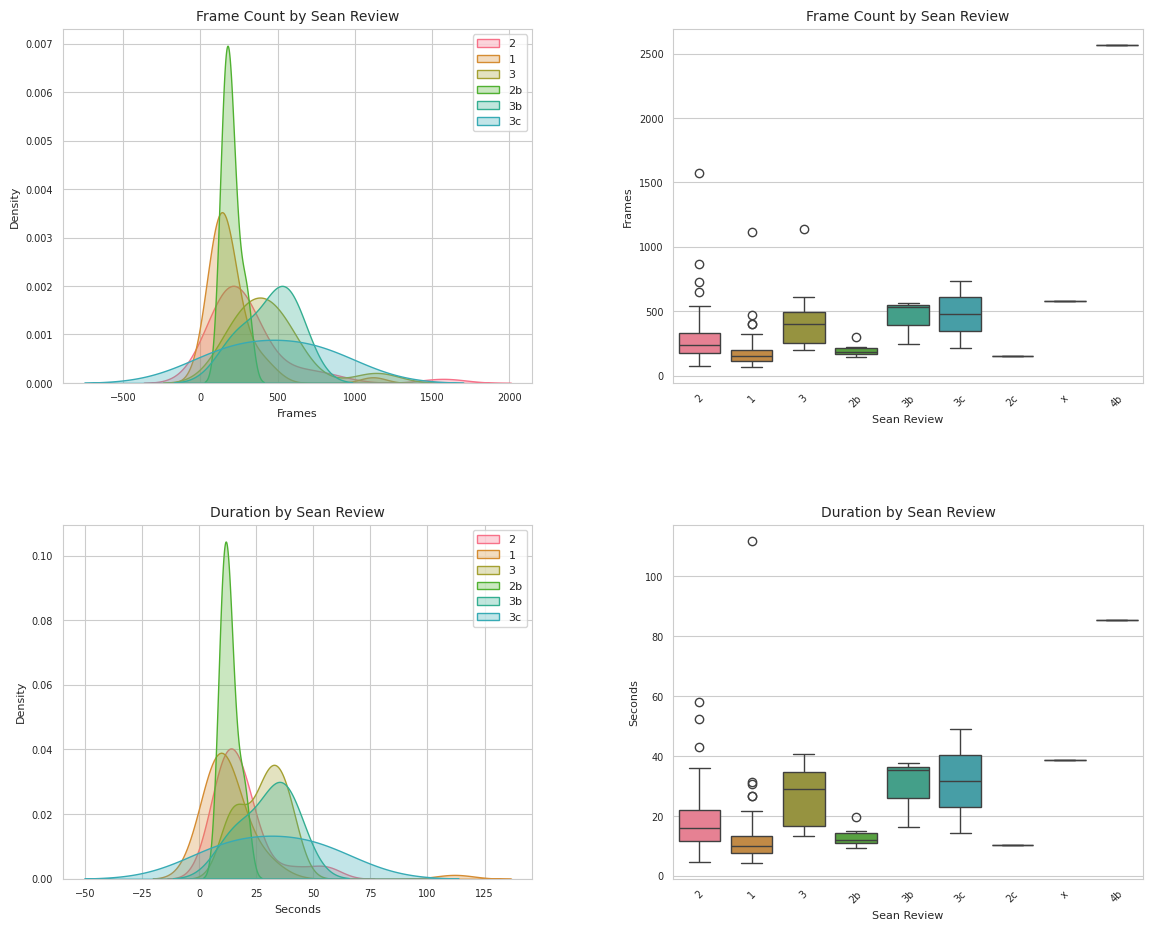

In [13]:

def visualize_sean_review_distributions(df, output_dir, display=False, fuse_plots=True):
    """
    Visualize distributions of Processed_Frame_Count and Processed_Duration_sec
    across unique Sean_Review categories using KDE and box plots.
    
    Args:
        df (pandas.DataFrame): Dataframe with Processed_Frame_Count, Processed_Duration_sec,
                              Sean_Review, and Processed_video_path columns
        output_dir (str): Directory to save plots
        display (bool): If True, display figures in Jupyter Notebook
        fuse_plots (bool): If True, combine plots into a single 2x2 figure; else, individual figures
    
    Returns:
        None (saves plots as PNG files and optionally displays figures)
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Filter valid rows (non-NaN Processed_video_path, Processed_Frame_Count, Processed_Duration_sec, Sean_Review)
    valid_df = df[df['Processed_video_path'].notna() & 
                  df['Processed_Frame_Count'].notna() & 
                  df['Processed_Duration_sec'].notna() & 
                  df['Sean_Review'].notna()]
    
    if valid_df.empty:
        print("No valid data after filtering. Check for NaN values or missing columns.")
        return
    
    # Get unique Sean_Review values
    unique_reviews = valid_df['Sean_Review'].unique()
    if len(unique_reviews) == 0:
        print("No unique Sean_Review values found.")
        return
    
    print(f"Unique Sean_Review values: {unique_reviews}")
    
    # Define columns to visualize
    columns = [
        ('Processed_Frame_Count', 'Frames', 'Frame Count'),
        ('Processed_Duration_sec', 'Seconds', 'Duration')
    ]
    
    # Set seaborn style and color palette
    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", len(unique_reviews))
    
    if fuse_plots:
        # Create a single figure with 2x2 subplots
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()
        
        for idx, (col, unit, title) in enumerate([(c[0], c[1], c[2]) for c in columns for _ in range(2)]):
            ax = axes[idx]
            plot_type = 'kde' if idx % 2 == 0 else 'box'
            
            if plot_type == 'kde':
                # KDE plot for each Sean_Review category
                for i, review in enumerate(unique_reviews):
                    data = valid_df[valid_df['Sean_Review'] == review][col].dropna()
                    sns.kdeplot(data=data, label=review, color=palette[i], fill=True, alpha=0.3, ax=ax)
                
                ax.set_title(f'{title} by Sean Review', fontsize=10)
                ax.set_xlabel(unit, fontsize=8)
                ax.set_ylabel('Density', fontsize=8)
                ax.legend(fontsize=8, loc='best')
                ax.tick_params(axis='both', labelsize=7)
            
            else:
                # Box plot for each Sean_Review category
                sns.boxplot(x='Sean_Review', y=col, data=valid_df, palette=palette, ax=ax)
                
                ax.set_title(f'{title} by Sean Review', fontsize=10)
                ax.set_xlabel('Sean Review', fontsize=8)
                ax.set_ylabel(unit, fontsize=8)
                ax.tick_params(axis='both', labelsize=7)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
        # Adjust layout for fused figure
        plt.tight_layout()
        plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.1, wspace=0.3, hspace=0.4)
        
        # Save fused figure
        fused_filename = 'sean_review_distributions.png'
        plt.savefig(os.path.join(output_dir, fused_filename), bbox_inches='tight')
        
        # Display fused figure in Jupyter if requested
        if display:
            plt.show()
        
        plt.close()
    
    # Generate individual plots (always saved, displayed if fuse_plots=False)
    for col, unit, title in columns:
        for plot_type in ['kde', 'box']:
            # Create individual figure
            plt.figure(figsize=(8, 4) if display else (10, 6))
            
            if plot_type == 'kde':
                # KDE plot for each Sean_Review category
                for i, review in enumerate(unique_reviews):
                    data = valid_df[valid_df['Sean_Review'] == review][col].dropna()
                    sns.kdeplot(data=data, label=review, color=palette[i], fill=True, alpha=0.3)
                
                plt.title(f'{title} by Sean Review')
                plt.xlabel(unit)
                plt.ylabel('Density')
                plt.legend()
            
            else:
                # Box plot for each Sean_Review category
                sns.boxplot(x='Sean_Review', y=col, data=valid_df, palette=palette)
                
                plt.title(f'{title} by Sean Review')
                plt.xlabel('Sean Review')
                plt.ylabel(unit)
                plt.xticks(rotation=45)
            
            # Adjust layout and save individual plot
            plt.tight_layout()
            filename = f"{col}_{plot_type}.png"
            plt.savefig(os.path.join(output_dir, filename))
            
            # Display individual plot in Jupyter if requested and not fusing
            if display and not fuse_plots:
                plt.show()
            
            plt.close()

# Example usage in Jupyter Notebook:
column_pairs = [
    ('Duration_sec', 'Processed_Duration_sec', 'kde', 'Seconds'),
    ('FPS', 'Processed_FPS', 'kde', 'Frames per Second'),
    ('Width', 'Processed_Width', 'bar', 'Pixels'),
    ('Height', 'Processed_Height', 'bar', 'Pixels'),
    ('Frame_Count', 'Processed_Frame_Count', 'bar', 'Frames')
]

output_dir = '/data/mskscratch/users/ghoyer/Precision_Air/notebooks/figures6'

# video_df = pd.read_csv('your_data.csv')  # Load your dataframe
visualize_sean_review_distributions(video_df, output_dir, display=True, fuse_plots=True)

Unique Sean_Review values: ['2' '1' '3' '2b' '3b' '3c' '2c' 'x' '4b']
Unique Santiago_Review values: ['2b' '1' '2d' '3' '3b' '2c' '2' '4b']


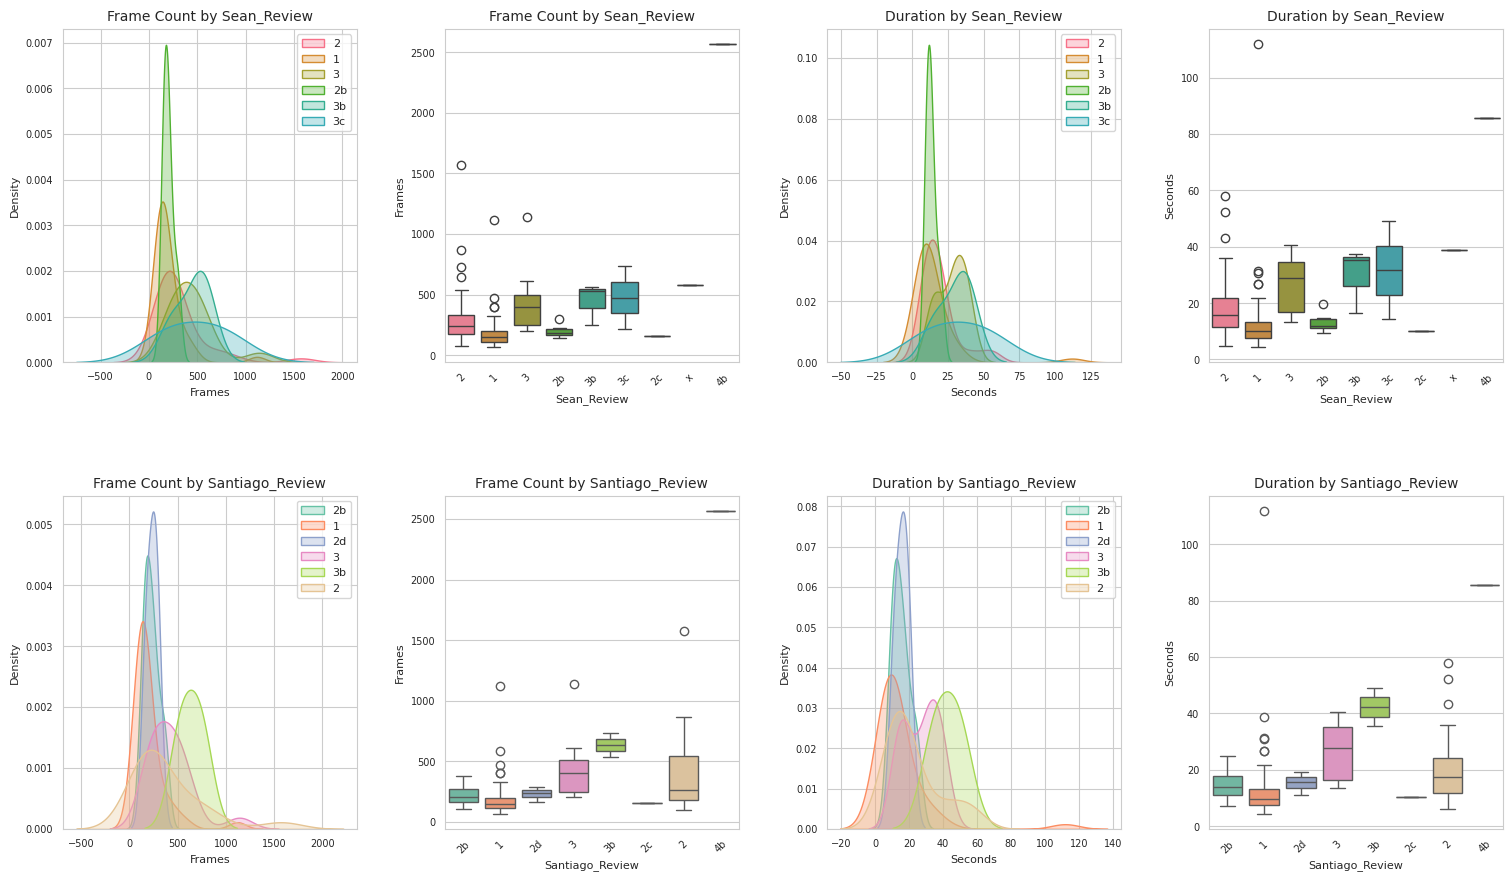

In [14]:
def visualize_two_graders_distributions(df, grader_columns, output_dir, display=False, fuse_plots=True):
    """
    Visualize distributions of Processed_Frame_Count and Processed_Duration_sec
    across unique categories of two graders' classifications using KDE and box plots.
    
    Args:
        df (pandas.DataFrame): Dataframe with Processed_Frame_Count, Processed_Duration_sec,
                              grader columns (e.g., Sean_Review, Santiago_Review), and Processed_video_path
        grader_columns (list): List of two column names for graders (e.g., ['Sean_Review', 'Santiago_Review'])
        output_dir (str): Directory to save plots
        display (bool): If True, display figures in Jupyter Notebook
        fuse_plots (bool): If True, combine plots into a single 2x4 figure; else, individual figures
    
    Returns:
        None (saves plots as PNG files and optionally displays figures)
    """
    # Validate grader_columns
    if len(grader_columns) != 2:
        print("grader_columns must contain exactly two column names.")
        return
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Filter valid rows (non-NaN Processed_video_path, Processed_Frame_Count, Processed_Duration_sec, and grader columns)
    valid_df = df[df['Processed_video_path'].notna() & 
                  df['Processed_Frame_Count'].notna() & 
                  df['Processed_Duration_sec'].notna() & 
                  df[grader_columns[0]].notna() & 
                  df[grader_columns[1]].notna()]
    
    if valid_df.empty:
        print("No valid data after filtering. Check for NaN values or missing columns.")
        return
    
    # Get unique values for each grader
    unique_values = {}
    for grader in grader_columns:
        unique_values[grader] = valid_df[grader].unique()
        if len(unique_values[grader]) == 0:
            print(f"No unique values found for {grader}.")
            return
        print(f"Unique {grader} values: {unique_values[grader]}")
    
    # Define columns to visualize
    columns = [
        ('Processed_Frame_Count', 'Frames', 'Frame Count'),
        ('Processed_Duration_sec', 'Seconds', 'Duration')
    ]
    
    # Set seaborn style and color palettes for each grader
    sns.set_style("whitegrid")
    palettes = {
        grader_columns[0]: sns.color_palette("husl", len(unique_values[grader_columns[0]])),
        grader_columns[1]: sns.color_palette("Set2", len(unique_values[grader_columns[1]]))
    }
    
    if fuse_plots:
        # Create a single figure with 2x4 subplots
        fig, axes = plt.subplots(2, 4, figsize=(16, 10))
        axes = axes.flatten()
        subplot_idx = 0
        
        for grader in grader_columns:
            for col, unit, title in columns:
                for plot_type in ['kde', 'box']:
                    ax = axes[subplot_idx]
                    
                    if plot_type == 'kde':
                        # KDE plot for each category
                        for i, category in enumerate(unique_values[grader]):
                            data = valid_df[valid_df[grader] == category][col].dropna()
                            sns.kdeplot(data=data, label=category, color=palettes[grader][i], 
                                       fill=True, alpha=0.3, ax=ax)
                        
                        ax.set_title(f'{title} by {grader}', fontsize=10)
                        ax.set_xlabel(unit, fontsize=8)
                        ax.set_ylabel('Density', fontsize=8)
                        ax.legend(fontsize=8, loc='best')
                        ax.tick_params(axis='both', labelsize=7)
                    
                    else:
                        # Box plot for each category
                        sns.boxplot(x=grader, y=col, data=valid_df, palette=palettes[grader], ax=ax)
                        
                        ax.set_title(f'{title} by {grader}', fontsize=10)
                        ax.set_xlabel(grader, fontsize=8)
                        ax.set_ylabel(unit, fontsize=8)
                        ax.tick_params(axis='both', labelsize=7)
                        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
                    
                    subplot_idx += 1
        
        # Adjust layout for fused figure
        plt.tight_layout()
        plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.4)
        
        # Save fused figure
        fused_filename = 'grader_distributions.png'
        plt.savefig(os.path.join(output_dir, fused_filename), bbox_inches='tight')
        
        # Display fused figure in Jupyter if requested
        if display:
            plt.show()
        
        plt.close()
    
    # Generate individual plots (always saved, displayed if fuse_plots=False)
    for grader in grader_columns:
        for col, unit, title in columns:
            for plot_type in ['kde', 'box']:
                # Create individual figure
                plt.figure(figsize=(8, 4) if display else (10, 6))
                
                if plot_type == 'kde':
                    # KDE plot for each category
                    for i, category in enumerate(unique_values[grader]):
                        data = valid_df[valid_df[grader] == category][col].dropna()
                        sns.kdeplot(data=data, label=category, color=palettes[grader][i], 
                                   fill=True, alpha=0.3)
                    
                    plt.title(f'{title} by {grader}')
                    plt.xlabel(unit)
                    plt.ylabel('Density')
                    plt.legend()
                
                else:
                    # Box plot for each category
                    sns.boxplot(x=grader, y=col, data=valid_df, palette=palettes[grader])
                    
                    plt.title(f'{title} by {grader}')
                    plt.xlabel(grader)
                    plt.ylabel(unit)
                    plt.xticks(rotation=45)
                
                # Adjust layout and save individual plot
                plt.tight_layout()
                filename = f"{col}_{grader}_{plot_type}.png"
                plt.savefig(os.path.join(output_dir, filename))
                
                # Display individual plot in Jupyter if requested and not fusing
                if display and not fuse_plots:
                    plt.show()
                
                plt.close()

# Example usage in Jupyter Notebook:
grader_columns = ['Sean_Review', 'Santiago_Review']
output_dir = '/data/mskscratch/users/ghoyer/Precision_Air/notebooks/figures7'

# video_df = pd.read_csv('your_data.csv')  # Load your dataframe
visualize_two_graders_distributions(video_df, grader_columns, output_dir, display=True, fuse_plots=True)

### looking at potential color trends in the Sean Review classifications

Unique Sean_Review values: ['2' '1' '3' '2b' '3b' '3c' '2c' 'x' '4b']


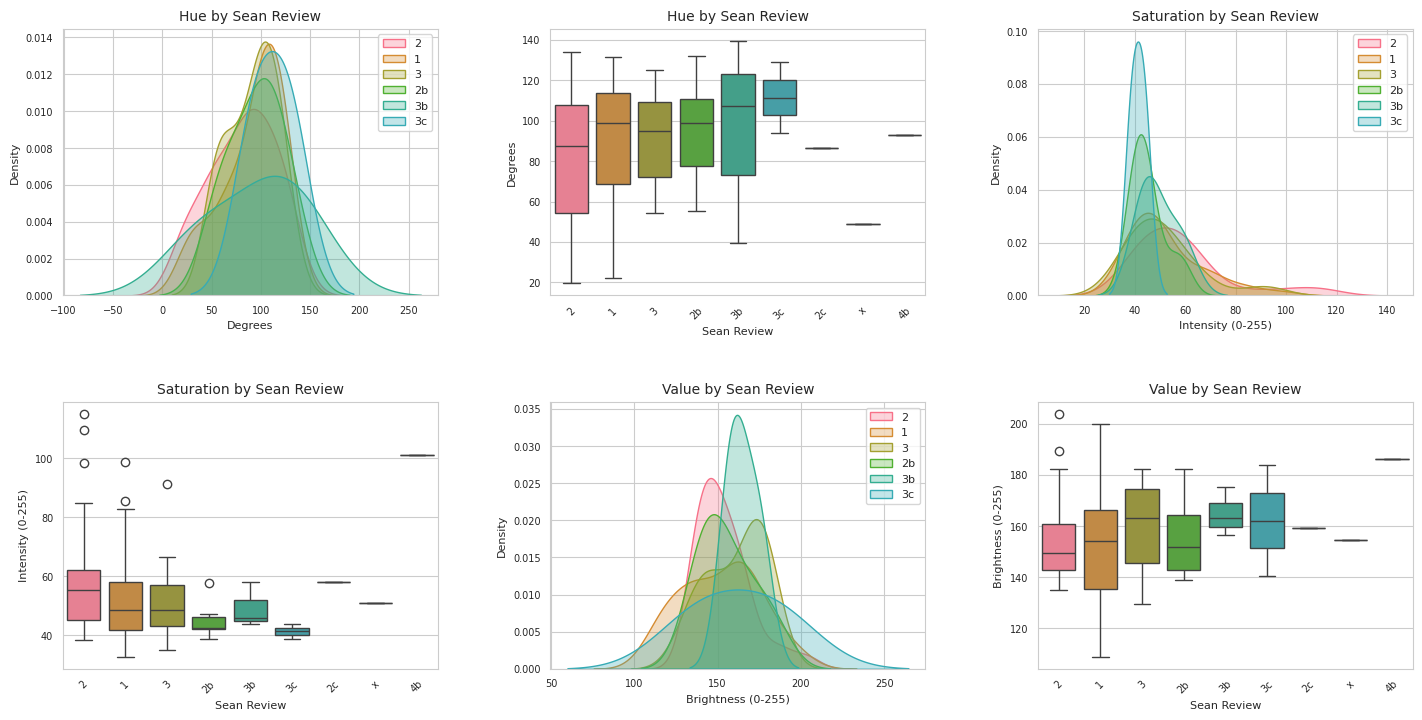

In [15]:

def visualize_sean_review_color_trends(df, output_dir, sample_rate=10, display=False, fuse_plots=True):
    """
    Extract average hue, saturation, and value from processed videos and visualize
    their distributions across Sean_Review categories using KDE and box plots.
    
    Args:
        df (pandas.DataFrame): Dataframe with Processed_video_path and Sean_Review columns
        output_dir (str): Directory to save plots
        sample_rate (int): Sample every nth frame for feature extraction (default: 10)
        display (bool): If True, display figures in Jupyter Notebook
        fuse_plots (bool): If True, combine plots into a single 2x3 figure; else, individual figures
    
    Returns:
        pandas.DataFrame: Input dataframe with added columns avg_hue, avg_saturation, avg_value
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Filter valid rows (non-NaN Processed_video_path and Sean_Review)
    valid_df = df[df['Processed_video_path'].notna() & df['Sean_Review'].notna()].copy()
    
    if valid_df.empty:
        print("No valid data after filtering. Check for NaN values or missing columns.")
        return df
    
    # Get unique Sean_Review values
    unique_reviews = valid_df['Sean_Review'].unique()
    if len(unique_reviews) == 0:
        print("No unique Sean_Review values found.")
        return df
    
    print(f"Unique Sean_Review values: {unique_reviews}")
    
    # Initialize columns for color metrics
    valid_df['avg_hue'] = np.nan
    valid_df['avg_saturation'] = np.nan
    valid_df['avg_value'] = np.nan
    
    # Extract color features from videos
    for idx, row in valid_df.iterrows():
        video_path = row['Processed_video_path']
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Cannot open video: {video_path}")
                continue
            
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if frame_count == 0:
                print(f"Empty video: {video_path}")
                cap.release()
                continue
            
            hues, saturations, values = [], [], []
            frame_idx = 0
            
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Sample every sample_rate frame
                if frame_idx % sample_rate == 0:
                    # Convert frame to HSV
                    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
                    # Compute mean HSV values
                    mean_hsv = hsv_frame.mean(axis=(0, 1))
                    # Filter low-variance frames (e.g., black frames)
                    if hsv_frame.std(axis=(0, 1)).mean() > 5:  # Arbitrary threshold
                        hues.append(mean_hsv[0])
                        saturations.append(mean_hsv[1])
                        values.append(mean_hsv[2])
                
                frame_idx += 1
            
            cap.release()
            
            # Store averages if valid data exists
            if hues:
                valid_df.at[idx, 'avg_hue'] = np.mean(hues)
                valid_df.at[idx, 'avg_saturation'] = np.mean(saturations)
                valid_df.at[idx, 'avg_value'] = np.mean(values)
            else:
                print(f"No valid frames processed for: {video_path}")
                
        except Exception as e:
            print(f"Error processing {video_path}: {str(e)}")
    
    # Drop rows with NaN color metrics
    valid_df = valid_df.dropna(subset=['avg_hue', 'avg_saturation', 'avg_value'])
    
    if valid_df.empty:
        print("No valid color metrics extracted.")
        return df
    
    # Define metrics to visualize
    metrics = [
        ('avg_hue', 'Degrees', 'Hue'),
        ('avg_saturation', 'Intensity (0-255)', 'Saturation'),
        ('avg_value', 'Brightness (0-255)', 'Value')
    ]
    
    # Set seaborn style and color palette
    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", len(unique_reviews))
    
    if fuse_plots:
        # Create a single figure with 2x3 subplots
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        axes = axes.flatten()
        subplot_idx = 0
        
        for col, unit, title in metrics:
            for plot_type in ['kde', 'box']:
                ax = axes[subplot_idx]
                
                if plot_type == 'kde':
                    # KDE plot for each Sean_Review category
                    for i, review in enumerate(unique_reviews):
                        data = valid_df[valid_df['Sean_Review'] == review][col].dropna()
                        sns.kdeplot(data=data, label=review, color=palette[i], fill=True, alpha=0.3, ax=ax)
                    
                    ax.set_title(f'{title} by Sean Review', fontsize=10)
                    ax.set_xlabel(unit, fontsize=8)
                    ax.set_ylabel('Density', fontsize=8)
                    ax.legend(fontsize=8, loc='best')
                    ax.tick_params(axis='both', labelsize=7)
                
                else:
                    # Box plot for each Sean_Review category
                    sns.boxplot(x='Sean_Review', y=col, data=valid_df, palette=palette, ax=ax)
                    
                    ax.set_title(f'{title} by Sean Review', fontsize=10)
                    ax.set_xlabel('Sean Review', fontsize=8)
                    ax.set_ylabel(unit, fontsize=8)
                    ax.tick_params(axis='both', labelsize=7)
                    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
                
                subplot_idx += 1
        
        # Adjust layout for fused figure
        plt.tight_layout()
        plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.4)
        
        # Save fused figure
        fused_filename = 'sean_review_color_trends.png'
        plt.savefig(os.path.join(output_dir, fused_filename), bbox_inches='tight')
        
        # Display fused figure in Jupyter if requested
        if display:
            plt.show()
        
        plt.close()
    
    # Generate individual plots (always saved, displayed if fuse_plots=False)
    for col, unit, title in metrics:
        for plot_type in ['kde', 'box']:
            # Create individual figure
            plt.figure(figsize=(8, 4) if display else (10, 6))
            
            if plot_type == 'kde':
                # KDE plot for each Sean_Review category
                for i, review in enumerate(unique_reviews):
                    data = valid_df[valid_df['Sean_Review'] == review][col].dropna()
                    sns.kdeplot(data=data, label=review, color=palette[i], fill=True, alpha=0.3)
                
                plt.title(f'{title} by Sean Review')
                plt.xlabel(unit)
                plt.ylabel('Density')
                plt.legend()
            
            else:
                # Box plot for each Sean_Review category
                sns.boxplot(x='Sean_Review', y=col, data=valid_df, palette=palette)
                
                plt.title(f'{title} by Sean Review')
                plt.xlabel('Sean Review')
                plt.ylabel(unit)
                plt.xticks(rotation=45)
            
            # Adjust layout and save individual plot
            plt.tight_layout()
            filename = f"{col}_{plot_type}.png"
            plt.savefig(os.path.join(output_dir, filename))
            
            # Display individual plot in Jupyter if requested and not fusing
            if display and not fuse_plots:
                plt.show()
            
            plt.close()
    
    return valid_df

# Example usage in Jupyter Notebook:
output_dir = '/data/mskscratch/users/ghoyer/Precision_Air/notebooks/figures8'

# video_df = pd.read_csv('your_data.csv')  # Load your dataframe
updated_df = visualize_sean_review_color_trends(video_df, output_dir, sample_rate=10, display=True, fuse_plots=True)

In [16]:

def assign_video_splits_by_sean_review(df, output_dir, split_ratios=(0.7, 0.15, 0.15), random_state=42):
    """
    Assign train/val/test splits to unique Video_IDs based on Sean_Review classifications,
    balancing splits by fine-grained classes or coarse severity groups, and add a split column.
    
    Args:
        df (pandas.DataFrame): Dataframe with Video_ID and Sean_Review columns
        output_dir (str): Directory to save updated DataFrame
        split_ratios (tuple): Ratios for train, val, test splits (default: (0.7, 0.15, 0.15))
        random_state (int): Random seed for reproducibility
    
    Returns:
        pandas.DataFrame: Dataframe with added 'split' column (train, val, test)
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Validate input DataFrame
    required_columns = ['Video_ID', 'Sean_Review']
    if not all(col in df.columns for col in required_columns):
        print(f"DataFrame must contain columns: {required_columns}")
        return df
    
    # Create a copy to avoid modifying the original
    df = df.copy()
    
    # Initialize split column
    df['split'] = np.nan
    
    # Remove duplicates, keeping first occurrence
    unique_df = df.drop_duplicates(subset='Video_ID', keep='first')
    
    # Filter out Sean_Review = 'x'
    stratification_df = unique_df[unique_df['Sean_Review'] != 'x']
    x_df = unique_df[unique_df['Sean_Review'] == 'x']
    
    if stratification_df.empty:
        print("No valid Sean_Review values (excluding 'x') for stratification.")
        return df
    
    # Define coarse severity groups
    def map_to_coarse_group(review):
        if pd.isna(review) or review == 'x':
            return None
        base = review[0]  # Extract numeric part (e.g., '2' from '2a')
        if base in ['1', '2', '3', '4']:
            return base
        return None
    
    stratification_df['coarse_group'] = stratification_df['Sean_Review'].apply(map_to_coarse_group)
    
    # Validate data size
    n_videos = len(stratification_df)
    if n_videos < 3:
        print(f"Too few unique Video_IDs ({n_videos}) to split into train/val/test.")
        return df
    
    # Calculate split sizes
    train_ratio, val_ratio, test_ratio = split_ratios
    n_train = int(n_videos * train_ratio)
    n_val = int(n_videos * val_ratio)
    n_test = n_videos - n_train - n_val  # Ensure all videos are assigned
    
    # Try fine-grained stratification first
    try:
        skf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=random_state)
        splits = list(skf.split(stratification_df, stratification_df['Sean_Review'], groups=stratification_df['Video_ID']))
        
        # Assign splits
        train_idx = splits[0][1]  # Use first fold for train (largest)
        val_idx = splits[1][1]
        test_idx = splits[2][1]
        
        stratification_df.loc[stratification_df.index[train_idx], 'split'] = 'train'
        stratification_df.loc[stratification_df.index[val_idx], 'split'] = 'val'
        stratification_df.loc[stratification_df.index[test_idx], 'split'] = 'test'
        
        print("Successfully stratified by fine-grained Sean_Review values.")
        
    except ValueError as e:
        print(f"Fine-grained stratification failed: {str(e)}. Falling back to coarse severity groups.")
        
        # Fallback to coarse groups
        try:
            skf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=random_state)
            splits = list(skf.split(stratification_df, stratification_df['coarse_group'], groups=stratification_df['Video_ID']))
            
            # Assign splits
            train_idx = splits[0][1]
            val_idx = splits[1][1]
            test_idx = splits[2][1]
            
            stratification_df.loc[stratification_df.index[train_idx], 'split'] = 'train'
            stratification_df.loc[stratification_df.index[val_idx], 'split'] = 'val'
            stratification_df.loc[stratification_df.index[test_idx], 'split'] = 'test'
            
            print("Successfully stratified by coarse severity groups.")
            
        except ValueError as e:
            print(f"Coarse stratification failed: {str(e)}. Assigning splits randomly.")
            
            # Random assignment as last resort
            indices = np.arange(len(stratification_df))
            np.random.seed(random_state)
            np.random.shuffle(indices)
            
            train_idx = indices[:n_train]
            val_idx = indices[n_train:n_train + n_val]
            test_idx = indices[n_train + n_val:]
            
            stratification_df.loc[stratification_df.index[train_idx], 'split'] = 'train'
            stratification_df.loc[stratification_df.index[val_idx], 'split'] = 'val'
            stratification_df.loc[stratification_df.index[test_idx], 'split'] = 'test'
    
    # Assign split for 'x' case (if exists)
    if not x_df.empty:
        # Assign to train (largest split) to minimize imbalance
        x_df['split'] = 'train'
        print("Assigned Sean_Review='x' to train split.")
    
    # Combine stratified and x data
    final_df = pd.concat([stratification_df, x_df])
    
    # Map splits back to original DataFrame (including duplicates)
    split_mapping = final_df.set_index('Video_ID')['split']
    df['split'] = df['Video_ID'].map(split_mapping)
    
    # Verify split distribution
    print("\nSplit distribution:")
    print(df.groupby(['split', 'Sean_Review']).size().unstack(fill_value=0))
    
    # Save updated DataFrame
    output_path = os.path.join(output_dir, 'video_splits.csv')
    df.to_csv(output_path, index=False)
    print(f"Updated DataFrame saved to: {output_path}")
    
    return df

# Example usage in Jupyter Notebook:
output_dir = '/data/mskscratch/users/ghoyer/Precision_Air/notebooks/figures9'

# video_df = pd.read_csv('your_data.csv')  # Load your dataframe
updated_df = assign_video_splits_by_sean_review(video_df, output_dir, split_ratios=(0.7, 0.15, 0.15))

Successfully stratified by fine-grained Sean_Review values.
Assigned Sean_Review='x' to train split.

Split distribution:
Sean_Review   1   2  2b  2c  3  3b  3c  4b  x
split                                        
test         14   9   1   0  6   1   0   0  0
train        15  10   1   1  3   2   2   1  1
val          11  13   4   0  4   0   0   0  0
Updated DataFrame saved to: /data/mskscratch/users/ghoyer/Precision_Air/notebooks/figures9/video_splits.csv


In [17]:

def drop_duplicate_video_ids(df, output_dir):
    """
    Drop duplicate rows based on Video_ID, keeping the first occurrence, and save the cleaned DataFrame.
    
    Args:
        df (pandas.DataFrame): Dataframe with Video_ID column
        output_dir (str): Directory to save deduplicated DataFrame
    
    Returns:
        pandas.DataFrame: Deduplicated DataFrame
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Validate input DataFrame
    if 'Video_ID' not in df.columns:
        print("DataFrame must contain 'Video_ID' column.")
        return df
    
    # Create a copy to avoid modifying the original
    df = df.copy()
    
    # Get initial row count
    initial_rows = len(df)
    
    # Drop duplicates, keeping first occurrence
    dedup_df = df.drop_duplicates(subset='Video_ID', keep='first')
    
    # Get final row count and number of duplicates dropped
    final_rows = len(dedup_df)
    duplicates_dropped = initial_rows - final_rows
    
    # Print feedback
    print(f"Initial rows: {initial_rows}")
    print(f"Final rows after deduplication: {final_rows}")
    print(f"Duplicates dropped: {duplicates_dropped}")
    print(f"Unique Video_IDs: {len(dedup_df['Video_ID'].unique())}")
    
    # Print unique Sean_Review values (if present)
    if 'Sean_Review' in dedup_df.columns:
        print(f"Unique Sean_Review values: {sorted(dedup_df['Sean_Review'].dropna().unique())}")
    
    # Save deduplicated DataFrame
    output_path = os.path.join(output_dir, 'deduplicated_videos.csv')
    # dedup_df.to_csv(output_path, index=False)
    print(f"Deduplicated DataFrame saved to: {output_path}")
    
    return dedup_df

# Example usage in Jupyter Notebook:
output_dir = '/data/mskscratch/users/ghoyer/Precision_Air/notebooks/figures9'

# video_df = pd.read_csv('your_data.csv')  # Load your dataframe
dedup_df = drop_duplicate_video_ids(video_df, output_dir)

# Optionally chain with split assignment
# from assign_video_splits_by_sean_review import assign_video_splits_by_sean_review
updated_df = assign_video_splits_by_sean_review(dedup_df, output_dir, split_ratios=(0.7, 0.15, 0.15))

Initial rows: 99
Final rows after deduplication: 96
Duplicates dropped: 3
Unique Video_IDs: 96
Unique Sean_Review values: ['1', '2', '2b', '2c', '3', '3b', '3c', '4b', 'x']
Deduplicated DataFrame saved to: /data/mskscratch/users/ghoyer/Precision_Air/notebooks/figures9/deduplicated_videos.csv
Successfully stratified by fine-grained Sean_Review values.
Assigned Sean_Review='x' to train split.

Split distribution:
Sean_Review   1   2  2b  2c  3  3b  3c  4b  x
split                                        
test         14   9   1   0  6   1   0   0  0
train        13  10   1   1  2   2   2   1  1
val          11  13   4   0  4   0   0   0  0
Updated DataFrame saved to: /data/mskscratch/users/ghoyer/Precision_Air/notebooks/figures9/video_splits.csv
